In [60]:
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
import math

from scipy.ndimage import gaussian_filter1d


# for classifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load
from uncertainties import ufloat

In [61]:
import os
current_directory = os.getcwd()
print(current_directory)

/global/u1/j/jlargett/DESI_SGA/Morphology


In [62]:
SGA = Table.read('SGA_M20_Data1.fits')
#SGA = Table.read('SGA_M20_Data_Test.fits')
SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z,GINI_G,GINI_R,GINI_Z,Asymmetry_G,Asymmetry_R,Asymmetry_Z,M20_G,M20_R,M20_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.004

In [63]:
# Look at morph types in SGA
unique, counts = np.unique(SGA['MORPHTYPE'], return_counts = True)
print(unique, counts)

MORPHTYPE
---------
         
         
  .E+..?.
  .E+..P*
  .E+4...
  .E...P*
  .I..9P.
  .IBS9..
  .L..+P*
  .L?....
      ...
      Sab
       Sb
      Sbc
       Sc
      Scd
       Sd
       Sm
     dIrr
dIrr/dSph
     dSph
    dSph?
Length = 65 rows [169164      3      1      3      1      1      1      2      1      1
      1      1      1      1      2      1      1      1      1      1
      1     35   1320      1   1117      1      5  45468   3251  11137
     26   2374    118    270      1    419      2   4749  14527  39252
    330    771    804    141    129    957   1492   3463   3763   3473
    783    499    459   2887   5990  11076  17294  28455   3382   2470
   1712     15      6      5      1]


In [64]:
# Adds a new column named 'T_TYPE' to the 'SGA' dataset filled with NaN (Not a Number) values.
SGA.add_column(np.nan, name='T_TYPE')

# assign numerical values to the 'T_TYPE' column based on the 'MORPHTYPE' values:

# Elliptical and dwarf ellipticals (MORPHTYPE == 'E'): Assigns a value of -5 to the 'T_TYPE' column for these types.
# 45468 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'E'] = -5

# Lenticulars (MORPHTYPE == 'S0' and 'S0-a'): Assigns values of -2 and 0, respectively.
# 4749
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'S0'] = -2
#14527
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'S0-a'] = 0

# Spirals (MORPHTYPE == 'Sa', 'Sab', 'Sb', 'Sbc', 'Sc', 'Scd', 'Sd'): Assigns values 1, 2, 3, 4, 5, 6, and 7, respectively.
# 2887 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sa'] = 1

# 5990
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sab'] = 2

# 11076 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sb'] = 3

#17294 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sbc'] = 4

#28455 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sc'] = 5

#3382
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Scd'] = 6

#2470 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sd'] = 7

# Irregulars (MORPHTYPE == 'Sm', 'Irr', 'dIrr', 'I'): Assigns a value of 9 to 'Sm' and 10 to the others.
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sm'] = 9
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Irr'] = 10
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'dIrr'] = 10
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'I'] = 10

# Dwarf spheroidal (MORPHTYPE == 'dSph'): Assigns a value of 11.
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'dSph'] = 11

In [65]:
# rearrange SGA table so that rows are ordered by the numerical values in the 'T_TYPE' column
SGA.sort('T_TYPE')

# get color and morph parameters on new table for random forest 
Relevant = Table([SGA['MORPHTYPE'], SGA['T_TYPE'], SGA['GRADIENT_G-Z'], SGA['GRADIENT_G-R'], SGA['GRADIENT_R-Z'], 
                 SGA['C_INDEX_R_r50_r90'], SGA['COLOR G-Z'], SGA['COLOR G-R'], SGA['COLOR R-Z'], SGA['GINI_G'], 
                  SGA['GINI_R'], SGA['GINI_Z'], SGA['BA'], SGA['Asymmetry_R'], SGA['Asymmetry_G'], SGA['Asymmetry_Z'],
                 SGA['M20_G'], SGA['M20_R'], SGA['M20_Z']])
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,BA,Asymmetry_R,Asymmetry_G,Asymmetry_Z,M20_G,M20_R,M20_Z
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,0.89236444,0.22086520493030548,0.24768468737602234,0.3547217547893524,-0.6975669859340095,-0.6967239122802223,-0.6978546979251118
E,-5.0,-0.53083605,-0.24365975,-0.2871763,0.20835827,1.6869307,1.0853043,0.6016264,0.6606828397718219,0.7005038312173211,0.7281851619187655,0.7714816,0.22769492864608765,0.2776549458503723,0.3561789095401764,-0.6983291776271033,-0.6981884553226426,-0.6983867261377322
E,-5.0,-0.09060609,-0.04634577,-0.044260323,0.17891355,1.5189896,0.9096937,0.60929585,0.7139756957916816,0.7329502034752609,0.7281722459210835,0.82604694,0.2127256989479065,0.3033459782600403,0.2683529853820801,-0.6989399494722414,-0.6978069936000074,-0.6988342188341722
E,-5.0,-0.105971575,-0.09282738,-0.013144195,0.14360416,1.7361784,1.0164785,0.71969986,0.7062869927954301,0.7252081943699109,0.8551951197953661,0.94990206,0.32186973094940186,0.37095385789871216,1.237820029258728,-0.6986665453891208,-0.6984266301794262,-0.689992870145624
E,-5.0,-0.66179395,-0.25598752,-0.40580642,0.24141927,1.4583244,0.9870472,0.47127724,0.7064318081341784,0.7293388709825479,0.7755526498439915,0.8060751,0.19068536162376404,0.17279790341854095,0.25300225615501404,-0.6968096560704496,-0.6972031365633037,-0.6981263245012916
E,-5.0,--,--,--,0.14834835,--,--,--,0.4676399443865718,0.4895451291153296,0.4952693186221861,0.83467984,0.38690653443336487,0.3055165708065033,0.612675130367279,-0.6988155510787184,-0.6986015434602189,-0.6987846258001352
E,-5.0,-0.42369863,-0.16379105,-0.2599076,0.2522917,1.7391319,1.0215645,0.71756744,0.7266267219365932,0.7483333668391309,0.7626366995012073,0.65211284,0.12108276039361954,0.18037772178649902,0.20768097043037415,-0.6962691613339614,-0.6986707980891607,-0.6973854291009924
E,-5.0,-0.089765996,-0.04370889,-0.046057105,0.19391565,1.5149117,0.86676025,0.6481514,0.7521861716033815,0.7576239948809366,0.7621323401235267,0.9079751,0.17852969467639923,0.1950448602437973,0.23334892094135284,-0.6978146726432917,-0.6961685648343668,-0.6971240846849287
E,-5.0,-0.108296275,0.006925285,-0.11522156,0.19418615,1.7074795,0.9784012,0.7290783,0.7923166096363903,0.7999565528978321,0.7985566154337043,0.64088607,0.11127287894487381,0.13190501928329468,0.17066706717014313,-0.6947465202636657,-0.6971661965001656,-0.694895231740071


In [66]:
# Group by ellipticals, spirals, lenticulars and irregulars (no barred galaxies)

# Adds a new column named 'TYPE' to the 'Relevant' table and initializes it with the label 'Undefined'.
Relevant.add_column('Undefined', name='TYPE')

spirals = [1, 2, 3, 4, 5, 6, 7]
for i in spirals:
    Relevant['TYPE'][Relevant['T_TYPE'] == i] = 'Spirals'

Relevant['TYPE'][Relevant['T_TYPE'] == -5] = 'Elliptic'

Relevant['TYPE'][Relevant['T_TYPE'] == -2] = 'Len'
Relevant['TYPE'][Relevant['T_TYPE'] == 0] = 'Len'

#Relevant['TYPE'][Relevant['T_TYPE'] == 9] = 'Irregular'
Relevant['TYPE'][Relevant['T_TYPE'] == 10] = 'Irregular'
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,BA,Asymmetry_R,Asymmetry_G,Asymmetry_Z,M20_G,M20_R,M20_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,0.89236444,0.22086520493030548,0.24768468737602234,0.3547217547893524,-0.6975669859340095,-0.6967239122802223,-0.6978546979251118,Elliptic
E,-5.0,-0.53083605,-0.24365975,-0.2871763,0.20835827,1.6869307,1.0853043,0.6016264,0.6606828397718219,0.7005038312173211,0.7281851619187655,0.7714816,0.22769492864608765,0.2776549458503723,0.3561789095401764,-0.6983291776271033,-0.6981884553226426,-0.6983867261377322,Elliptic
E,-5.0,-0.09060609,-0.04634577,-0.044260323,0.17891355,1.5189896,0.9096937,0.60929585,0.7139756957916816,0.7329502034752609,0.7281722459210835,0.82604694,0.2127256989479065,0.3033459782600403,0.2683529853820801,-0.6989399494722414,-0.6978069936000074,-0.6988342188341722,Elliptic
E,-5.0,-0.105971575,-0.09282738,-0.013144195,0.14360416,1.7361784,1.0164785,0.71969986,0.7062869927954301,0.7252081943699109,0.8551951197953661,0.94990206,0.32186973094940186,0.37095385789871216,1.237820029258728,-0.6986665453891208,-0.6984266301794262,-0.689992870145624,Elliptic
E,-5.0,-0.66179395,-0.25598752,-0.40580642,0.24141927,1.4583244,0.9870472,0.47127724,0.7064318081341784,0.7293388709825479,0.7755526498439915,0.8060751,0.19068536162376404,0.17279790341854095,0.25300225615501404,-0.6968096560704496,-0.6972031365633037,-0.6981263245012916,Elliptic
E,-5.0,--,--,--,0.14834835,--,--,--,0.4676399443865718,0.4895451291153296,0.4952693186221861,0.83467984,0.38690653443336487,0.3055165708065033,0.612675130367279,-0.6988155510787184,-0.6986015434602189,-0.6987846258001352,Elliptic
E,-5.0,-0.42369863,-0.16379105,-0.2599076,0.2522917,1.7391319,1.0215645,0.71756744,0.7266267219365932,0.7483333668391309,0.7626366995012073,0.65211284,0.12108276039361954,0.18037772178649902,0.20768097043037415,-0.6962691613339614,-0.6986707980891607,-0.6973854291009924,Elliptic
E,-5.0,-0.089765996,-0.04370889,-0.046057105,0.19391565,1.5149117,0.86676025,0.6481514,0.7521861716033815,0.7576239948809366,0.7621323401235267,0.9079751,0.17852969467639923,0.1950448602437973,0.23334892094135284,-0.6978146726432917,-0.6961685648343668,-0.6971240846849287,Elliptic
E,-5.0,-0.108296275,0.006925285,-0.11522156,0.19418615,1.7074795,0.9784012,0.7290783,0.7923166096363903,0.7999565528978321,0.7985566154337043,0.64088607,0.11127287894487381,0.13190501928329468,0.17066706717014313,-0.6947465202636657,-0.6971661965001656,-0.694895231740071,Elliptic


In [67]:
# identify and count the galaxies in the 'Relevant' table that haven't been assigned specific types and are labeled as 'Undefined' in the 'TYPE' column.
Relevant[Relevant['TYPE'] == 'Undefined']
n = len(Relevant[Relevant['TYPE'] == 'Undefined'])

In [68]:
# remove all rows with undefined morph type
Relevant.sort('TYPE')
Relevant.remove_rows([range((len(Relevant) - n),len(Relevant))])
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,BA,Asymmetry_R,Asymmetry_G,Asymmetry_Z,M20_G,M20_R,M20_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,0.89236444,0.22086520493030548,0.24768468737602234,0.3547217547893524,-0.6975669859340095,-0.6967239122802223,-0.6978546979251118,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,0.7157851481129739,0.7319610826183206,0.7056223200583196,0.78316826,0.17434419691562653,0.24031183123588562,0.3726341724395752,-0.6955921274465968,-0.6972275818909534,-0.6988884496279404,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,0.6431034192497164,0.6706981295687374,0.74193224509162,0.7709117,0.5306020379066467,0.5669066905975342,0.669762134552002,-0.6975060036240716,-0.6971674194554952,-0.6967589300242316,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,0.7366244769669638,0.7550234441902871,0.766530397253896,0.75593334,0.23011770844459534,0.3396299481391907,0.1949983686208725,-0.6961573917038449,-0.6963130713033714,-0.6983207623880504,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,0.7919229773277829,0.8064153025155713,0.820757734303387,0.71132773,0.1168198361992836,0.10830502957105637,0.14521805942058563,-0.6961543942403714,-0.6968504397608086,-0.6929624503736083,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,0.7504674289273621,0.7600661682150734,0.7970225414866451,0.89952433,0.14017033576965332,0.1130504459142685,0.14751598238945007,-0.6986145934896413,-0.6951635794321989,-0.6989200882246474,Elliptic
E,-5.0,--,--,--,--,--,--,--,0.6419232870907602,0.6441716629634248,0.7627260031650012,0.978524,0.6087396144866943,0.6386452913284302,0.788008451461792,-0.6989051862106649,-0.6989689602896839,-0.6986136503742562,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,0.8011237485594123,0.8137575667685386,0.8417360250807098,0.5428148,0.4503416419029236,0.4458245038986206,0.6285513639450073,-0.6988695372560156,-0.6987499783562473,-0.6986209281897456,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,0.6727668854714033,0.6971990942255121,0.6797460933908485,0.8140076,0.24588161706924438,0.38194501399993896,0.4165848195552826,-0.6981525688481705,-0.6980121538781277,-0.6976652472662139,Elliptic


In [69]:
filtering_for_classifier = np.logical_not(Relevant['GRADIENT_G-Z'].mask)& np.logical_not(Relevant['GRADIENT_G-R'].mask)& np.logical_not(Relevant['GRADIENT_R-Z'].mask) & np.logical_not(Relevant['C_INDEX_R_r50_r90'].mask)& np.logical_not(Relevant['COLOR G-Z'].mask) & np.logical_not(Relevant['COLOR G-R'].mask)& np.logical_not(Relevant['COLOR R-Z'].mask)& np.logical_not(Relevant['GINI_R'].mask)& np.logical_not(Relevant['GINI_G'].mask)& np.logical_not(Relevant['GINI_Z'].mask)& np.logical_not(Relevant['Asymmetry_G'].mask)& np.logical_not(Relevant['Asymmetry_R'].mask)& np.logical_not(Relevant['Asymmetry_Z'].mask)& np.logical_not(Relevant['M20_G'].mask)& np.logical_not(Relevant['M20_R'].mask)& np.logical_not(Relevant['M20_Z'].mask)

#'Data' that includes only the rows where all the specified columns have valid (non-masked) data.
Data = Relevant[filtering_for_classifier]
Data

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,BA,Asymmetry_R,Asymmetry_G,Asymmetry_Z,M20_G,M20_R,M20_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,0.89236444,0.22086520493030548,0.24768468737602234,0.3547217547893524,-0.6975669859340095,-0.6967239122802223,-0.6978546979251118,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,0.7157851481129739,0.7319610826183206,0.7056223200583196,0.78316826,0.17434419691562653,0.24031183123588562,0.3726341724395752,-0.6955921274465968,-0.6972275818909534,-0.6988884496279404,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,0.6431034192497164,0.6706981295687374,0.74193224509162,0.7709117,0.5306020379066467,0.5669066905975342,0.669762134552002,-0.6975060036240716,-0.6971674194554952,-0.6967589300242316,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,0.7366244769669638,0.7550234441902871,0.766530397253896,0.75593334,0.23011770844459534,0.3396299481391907,0.1949983686208725,-0.6961573917038449,-0.6963130713033714,-0.6983207623880504,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,0.7919229773277829,0.8064153025155713,0.820757734303387,0.71132773,0.1168198361992836,0.10830502957105637,0.14521805942058563,-0.6961543942403714,-0.6968504397608086,-0.6929624503736083,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,0.7504674289273621,0.7600661682150734,0.7970225414866451,0.89952433,0.14017033576965332,0.1130504459142685,0.14751598238945007,-0.6986145934896413,-0.6951635794321989,-0.6989200882246474,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,0.8011237485594123,0.8137575667685386,0.8417360250807098,0.5428148,0.4503416419029236,0.4458245038986206,0.6285513639450073,-0.6988695372560156,-0.6987499783562473,-0.6986209281897456,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,0.6727668854714033,0.6971990942255121,0.6797460933908485,0.8140076,0.24588161706924438,0.38194501399993896,0.4165848195552826,-0.6981525688481705,-0.6980121538781277,-0.6976652472662139,Elliptic
E,-5.0,-0.10071872,-0.08763887,-0.013079852,0.23602146,1.5228395,0.8931446,0.62969494,0.6932573719148509,0.7121325460556305,0.7113957789334985,0.619575,0.23004212975502014,0.24715757369995117,0.2672399878501892,-0.695417118147692,-0.6954533026608998,-0.6942995313573616,Elliptic


In [70]:
unique, counts = np.unique(Data['MORPHTYPE'], return_counts = True)
print(unique, counts)

MORPHTYPE
---------
        E
        I
       S0
     S0-a
       Sa
      Sab
       Sb
      Sbc
       Sc
      Scd
       Sd
     dIrr [40821  2034  4226 13306  2594  5451 10118 15918 26492  3115  2274     8]


In [71]:
unique, counts = np.unique(Data['TYPE'], return_counts = True)
print(unique, counts)

   TYPE  
---------
 Elliptic
Irregular
      Len
  Spirals [40821  2042 17532 65962]


In [76]:
# Get equal samples for all general types of galaxies.
sample_elliptical = Data[Data['TYPE'] == 'Elliptic'][:2042]
sample_lenticular = Data[Data['TYPE'] == 'Len'][:2042]
sample_spirals = Data[Data['TYPE'] == 'Spirals'][:2042]
sample_irregular = Data[Data['TYPE'] == 'Irregular']
new_data = vstack([sample_elliptical, sample_lenticular, sample_spirals, sample_irregular])
new_data

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,BA,Asymmetry_R,Asymmetry_G,Asymmetry_Z,M20_G,M20_R,M20_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,0.89236444,0.22086520493030548,0.24768468737602234,0.3547217547893524,-0.6975669859340095,-0.6967239122802223,-0.6978546979251118,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,0.7157851481129739,0.7319610826183206,0.7056223200583196,0.78316826,0.17434419691562653,0.24031183123588562,0.3726341724395752,-0.6955921274465968,-0.6972275818909534,-0.6988884496279404,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,0.6431034192497164,0.6706981295687374,0.74193224509162,0.7709117,0.5306020379066467,0.5669066905975342,0.669762134552002,-0.6975060036240716,-0.6971674194554952,-0.6967589300242316,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,0.7366244769669638,0.7550234441902871,0.766530397253896,0.75593334,0.23011770844459534,0.3396299481391907,0.1949983686208725,-0.6961573917038449,-0.6963130713033714,-0.6983207623880504,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,0.7919229773277829,0.8064153025155713,0.820757734303387,0.71132773,0.1168198361992836,0.10830502957105637,0.14521805942058563,-0.6961543942403714,-0.6968504397608086,-0.6929624503736083,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,0.7504674289273621,0.7600661682150734,0.7970225414866451,0.89952433,0.14017033576965332,0.1130504459142685,0.14751598238945007,-0.6986145934896413,-0.6951635794321989,-0.6989200882246474,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,0.8011237485594123,0.8137575667685386,0.8417360250807098,0.5428148,0.4503416419029236,0.4458245038986206,0.6285513639450073,-0.6988695372560156,-0.6987499783562473,-0.6986209281897456,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,0.6727668854714033,0.6971990942255121,0.6797460933908485,0.8140076,0.24588161706924438,0.38194501399993896,0.4165848195552826,-0.6981525688481705,-0.6980121538781277,-0.6976652472662139,Elliptic
E,-5.0,-0.10071872,-0.08763887,-0.013079852,0.23602146,1.5228395,0.8931446,0.62969494,0.6932573719148509,0.7121325460556305,0.7113957789334985,0.619575,0.23004212975502014,0.24715757369995117,0.2672399878501892,-0.695417118147692,-0.6954533026608998,-0.6942995313573616,Elliptic


In [77]:
unique, counts = np.unique(new_data['TYPE'], return_counts = True)
print(unique, counts)

   TYPE  
---------
 Elliptic
Irregular
      Len
  Spirals [2042 2042 2042 2042]


In [78]:
# Determine the correct shapes of the array
# preparing the input features (X) and target labels (y) for the ML model
N = len(new_data)
X = np.zeros((N,17)) 

# Basically copying columns to associate later
X[:,0]= new_data['GRADIENT_G-Z']
X[:,1]= new_data['GRADIENT_G-R']
X[:,2]= new_data['GRADIENT_R-Z']
X[:,3]= new_data['C_INDEX_R_r50_r90']
X[:,4]= new_data['COLOR G-Z']
X[:,5]= new_data['COLOR G-R']
X[:,6]= new_data['COLOR R-Z']
X[:,7]= new_data['GINI_G']
X[:,8]= new_data['GINI_R']
X[:,9]= new_data['GINI_Z']
X[:,10]= new_data['BA']
X[:,11]= new_data['Asymmetry_G']
X[:,12]= new_data['Asymmetry_R']
X[:,13]= new_data['Asymmetry_Z']
X[:,14]= new_data['M20_G']
X[:,15]= new_data['M20_R']
X[:,16]= new_data['M20_Z']


# Target data array
y = np.array(new_data['TYPE'])
print(X.size, y.size)

138856 8168


In [79]:
# Train and test data samples
# 30% of the data will be used for testing, and the remaining 70% will be used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape

((5717, 17), (2451, 17))

In [80]:
y_train.shape, y_test.shape

((5717,), (2451,))

In [81]:
print("Data type of y_train:", y_train.dtype)
print("Data type of y_test:", y_test.dtype)

Data type of y_train: <U9
Data type of y_test: <U9


In [82]:
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_test:", len(y_test))
print("Number of samples in X_train:", len(y_train))
print("Number of samples in y_train:", len(y_train))

Number of samples in X_test: 2451
Number of samples in y_test: 2451
Number of samples in X_train: 5717
Number of samples in y_train: 5717


In [83]:
# Check for missing values in X_train
print("Missing values in X_train:", np.isnan(X_train).sum())

Missing values in X_train: 0


In [84]:
# create random forest
random_forest_100 = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set
classification_fit = random_forest_100.fit(X_train, y_train)

# predict on the test set results
y_pred = random_forest_100.predict(X_test)

# check accuracy score 
print('Model accuracy score with 100 decision trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
accuracy = accuracy_score(y_test, y_pred,normalize=False)
print('Correctly classified points =', accuracy)

Model accuracy score with 100 decision trees : 0.7438
Correctly classified points = 1823


In [85]:
# Evaluate the classifier
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Elliptic       0.76      0.64      0.70       649
   Irregular       0.83      0.82      0.83       583
         Len       0.63      0.69      0.66       576
     Spirals       0.77      0.82      0.79       643

    accuracy                           0.74      2451
   macro avg       0.75      0.74      0.74      2451
weighted avg       0.75      0.74      0.74      2451



In [86]:
feature_scores = random_forest_100.feature_importances_
feature_scores

array([0.04202691, 0.06570651, 0.03991158, 0.10777757, 0.09132967,
       0.12925151, 0.07840593, 0.03737931, 0.04843396, 0.06283863,
       0.06788113, 0.03114749, 0.03393856, 0.06428446, 0.03128022,
       0.03386004, 0.03454653])

In [87]:
# represent the relative importance of each feature in making predictions
feature_scores = random_forest_100.feature_importances_

array = np.array([['Gradient_G-Z', feature_scores[0]], ['Gradient_G-R',  feature_scores[1]], 
                  ['Gradient_R_Z', feature_scores[2]], ['C_INDEX_R_r50_r90', feature_scores[3]],  
                  ['COLOR G-Z', feature_scores[4]], ['COLOR G-R', feature_scores[5]], ['COLOR R-Z', feature_scores[6]],
                ['GINI_G', feature_scores[7]], ['GINI_R', feature_scores[8]], ['GINI_Z', feature_scores[9]], ['BA', feature_scores[10]], 
                  ['ASYMMETRY_G', feature_scores[11]], ['ASYMMETRY_R', feature_scores[12]], ['ASYMMETRY_Z', feature_scores[13]],
                 ['M20_G', feature_scores[14]], ['M20_R', feature_scores[15]], ['M20_Z', feature_scores[16]]]) 

column_values = ['Parameters', 'Feature_Scores'] 

index_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] 

Feature_scores = pd.DataFrame(data = array,  
                  index = index_values,  
                  columns = column_values) 

# displaying the dataframe
Feature_scores.sort_values(by=['Feature_Scores'], ascending=False)

,Parameters,Feature_Scores
6,COLOR G-R,0.12925151157912085
4,C_INDEX_R_r50_r90,0.10777756521501307
5,COLOR G-Z,0.09132966519916287
7,COLOR R-Z,0.07840592901377276
11,BA,0.06788113240414213
2,Gradient_G-R,0.06570651303097774
14,ASYMMETRY_Z,0.06428446269734389
10,GINI_Z,0.06283863325545541
9,GINI_R,0.0484339590739639
1,Gradient_G-Z,0.04202690556661081


In [88]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[418  32 163  36]
 [  5 477  25  76]
 [121   5 400  50]
 [  9  59  47 528]]


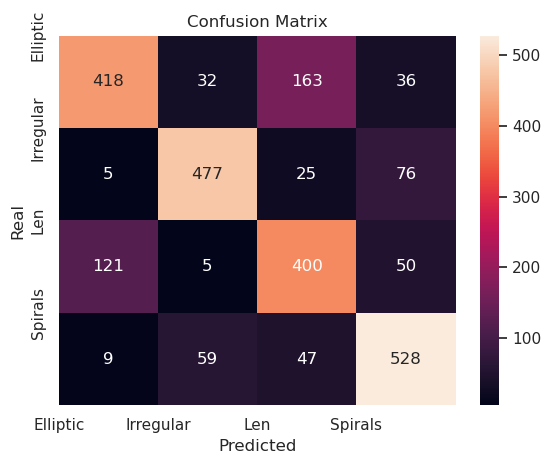

In [89]:
# Visualizing confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(np.unique(y))), np.unique(y))
plt.yticks(np.arange(len(np.unique(y))), np.unique(y))

plt.show()

In [90]:
# normalizing the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
poisson = np.sqrt(cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.6440678 , 0.04930663, 0.25115562, 0.05546995],
       [0.00857633, 0.81818182, 0.04288165, 0.13036021],
       [0.21006944, 0.00868056, 0.69444444, 0.08680556],
       [0.01399689, 0.09175739, 0.07309487, 0.82115086]])

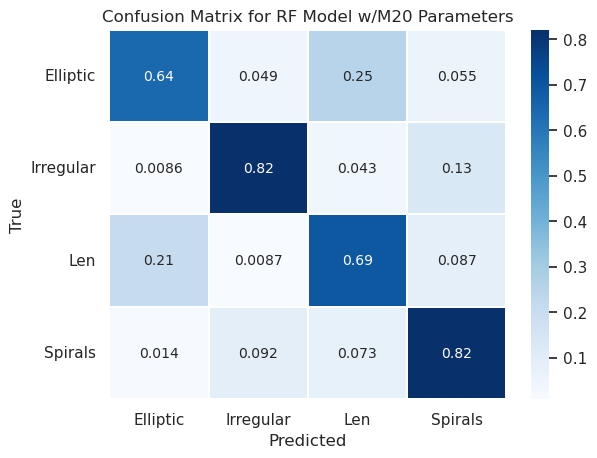

In [91]:
# Get and reshape confusion matrix data
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#poisson = np.sqrt(cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]

# Build the plot
sns.set(font_scale=1.0)
sns.heatmap(cm, annot=True, annot_kws={'size':10}, linewidths=0.2, cmap = 'Blues')

# Add labels to the plot
class_names = ['Elliptic', 'Irregular', 'Len', 'Spirals']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks + 0.5, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF Model w/M20 Parameters')
plt.show()